In [1]:
import pandas as pd
import numpy as np
import itertools as it
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc('axes', axisbelow=True)
%matplotlib inline

# Preliminaries, make variables for plotting and labels

In [2]:
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
month_abbrev = {'08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec','01':'Jan',
                '02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul'}

now = datetime.now()
today = now.strftime("%Y-%m-%d")
start = '2020-08-01'

alldates = pd.date_range(start=start, end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
date_dict = dict(zip(DATE_DF['date'].values, list(range(len(DATE_DF['date'].values)))))
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()

# Load data from google sheets
https://docs.google.com/spreadsheets/d/1YJt62E16PZkIl2ZPTUhm2fFVdRT6BKidswFKT6aIZsk/edit?usp=sharing

In [3]:
# get school names, abbreviations, colors, etc.
school_deets = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
                           '1YJt62E16PZkIl2ZPTUhm2fFVdRT6BKidswFKT6aIZsk/gviz/tq?tqx=out:csv&sheet=refs')

In [4]:
# names of all the tabs in the google sheet
blist = ['Northeastern','BU','Harvard','BC','MIT','Emerson','Bentley','Suffolk','Tufts','UMB','Wentworth',
         'Lasell','Brandeis','Berklee','Simmons','Emmanuel','Curry','MassArt','UMassAmherst']

In [5]:
# span through each google sheet and append it to a single dataframe
bout = []
for b in blist:
    boston_d = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
                           '1YJt62E16PZkIl2ZPTUhm2fFVdRT6BKidswFKT6aIZsk/gviz/tq?tqx=out:csv&sheet=%s'%b)
    boston_d = boston_d[['date','total_tests','positive_tests','university','url','enrollment']].copy()

    boston_dx = DATE_DF.copy()
    boston_dx['university'] = boston_d['university'].dropna().unique()[0]
    boston_dx['enrollment'] = boston_d['enrollment'].dropna().unique()[0]
    boston_dx['url'] = boston_d['url'].dropna().unique()[0]
    boston_dx = boston_dx.merge(boston_d[['date','total_tests','positive_tests']],how='left',on='date')
    boston_dx['total_tests'] = np.nan_to_num(boston_dx['total_tests'])
    boston_dx['positive_tests'] = np.nan_to_num(boston_dx['positive_tests'])
    boston_dx['total_tests'] = boston_dx['total_tests'].astype(str).str.replace(',','').astype(float)
    boston_dx['total_tests'] = np.nan_to_num(boston_dx['total_tests'])
    boston_d = boston_dx.loc[(boston_dx['date']<=today)&(boston_dx['date']>=start)].copy()
    
    bout.append(boston_d)
    
boston_data = pd.concat(bout).reset_index().iloc[:,1:]
boston_g = boston_data.groupby(['week','university','enrollment']).agg({
                                'date':'min','total_tests':'sum','positive_tests':'sum'}).reset_index()

In [6]:
boston_data.to_csv('../data/boston_area_ihe_data.csv',index=False)

# Plot a big jumble of case counts over time

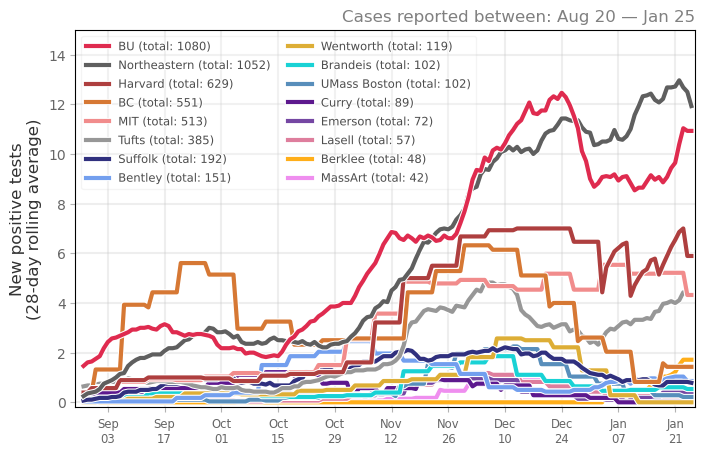

In [7]:
wid = 28
lw = 3
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)

for ui, univ in enumerate(school_deets['name'].unique()[:16]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev_name'].values[0]

    data_u = boston_data.loc[boston_data['university']==univ].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    totsum = sum(data_u['positive_tests'].values)
    yvals_u = data_u['positive_tests'].values
    yvalr_u = data_u['positive_tests'].rolling(window=wid).mean().values

    ax.plot(xvals_u, yvalr_u, color=univ_col, linewidth=lw, alpha=0.9,
            label='%s (total: %i)'%(univ_abb,totsum), zorder=wid-ui,
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'), path_effects.Normal()])

l = ax.legend(fontsize='small',framealpha=0.2,loc=2,ncol=2,columnspacing=1.5)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])
l.set_zorder(20)

date_labs = data_u['date'].values[5::14]
ax.set_xticks([date_dict[i] for i in date_labs])
ax.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in date_labs],fontsize='small')

ax.set_ylim(-0.2,15)
ax.set_xlim(date_dict['2020-08-26'], date_dict[today]+1)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')
ax.set_ylabel('New positive tests\n(%i-day rolling average)'%wid, color='.2',fontsize='large')
ax.set_title("Cases reported between: %s — %s"%(
               month_abbrev[date_labs[1][5:7]]+" "+date_labs[1][8:],
               month_abbrev[today[5:7]]+" "+today[8:]), x=1.0, ha='right', color='.5')

plt.savefig('../figs/pngs/university.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university.pdf', bbox_inches='tight')

plt.show()

# Same plot but with the "per 1000" corrections

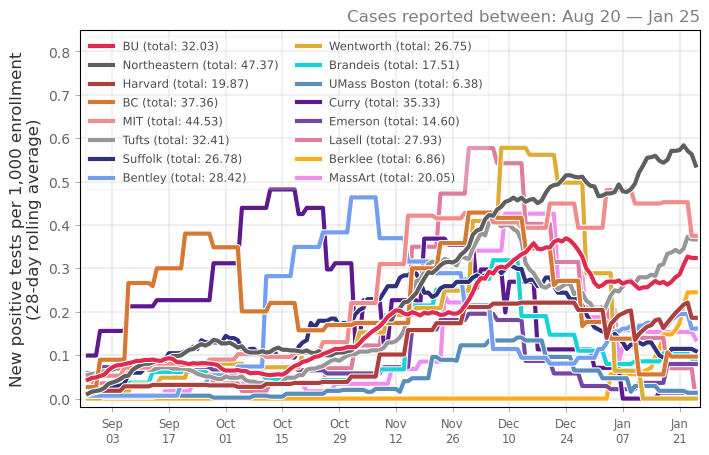

In [8]:
wid = 28
lw = 3
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)

for ui, univ in enumerate(school_deets['name'].unique()[:16]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev_name'].values[0]

    data_u = boston_data.loc[boston_data['university']==univ].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    yvals_u = data_u['positive_tests'].values
    yvalr_u = data_u['positive_tests'].rolling(window=wid).mean().values
    yvalr_u_per = yvalr_u / np.nanmean(data_u['enrollment']) * 1000
    totsum = sum(data_u['positive_tests'].values) / np.nanmean(data_u['enrollment']) * 1000
    
    ax.plot(xvals_u, yvalr_u_per, color=univ_col, linewidth=lw, alpha=0.9,
            label='%s (total: %.2f)'%(univ_abb,totsum), zorder=wid-ui,
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'), path_effects.Normal()])
            

l = ax.legend(fontsize='small',framealpha=0.2,loc=2,ncol=2,columnspacing=1.5)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])
l.set_zorder(20)

date_labs = data_u['date'].values[5::14]
ax.set_xticks([date_dict[i] for i in date_labs])
ax.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in date_labs],fontsize='small')
ax.set_ylim(-0.02,0.85)
ax.set_xlim(date_dict['2020-08-26'], date_dict[today]+1)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')
ax.set_ylabel('New positive tests per 1,000 enrollment\n(%i-day rolling average)'%wid,
              color='.2',fontsize='large')
ax.set_title("Cases reported between: %s — %s"%(
               month_abbrev[date_labs[1][5:7]]+" "+date_labs[1][8:],
               month_abbrev[today[5:7]]+" "+today[8:]), x=1.0, ha='right', color='.5')

plt.savefig('../figs/pngs/university_per_1000.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_per_1000.pdf', bbox_inches='tight')

plt.show()

# Grid of weekly sums of case counts

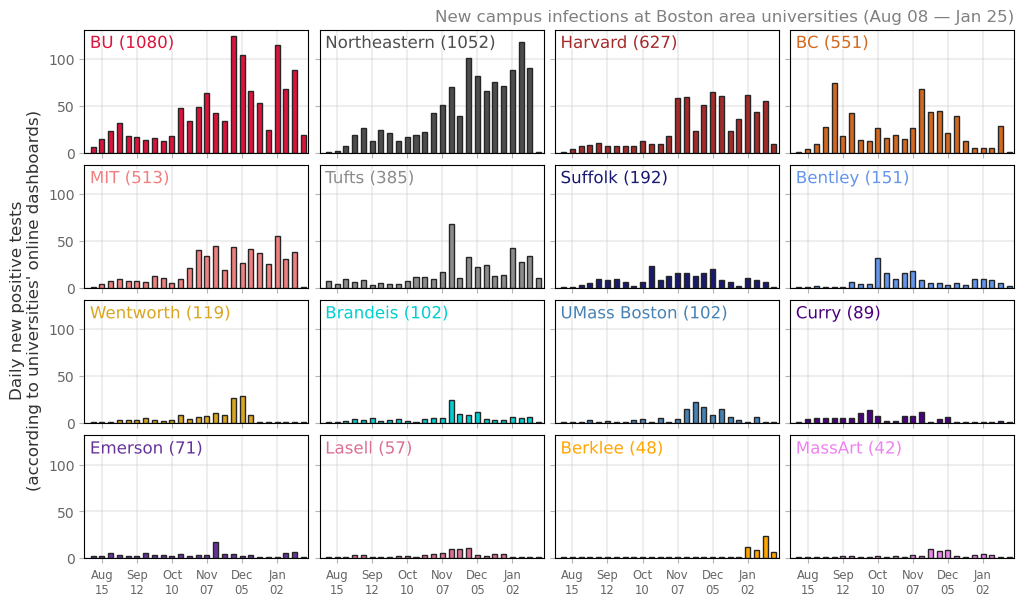

In [9]:
w = 3.0; h = 1.75
ncols = 4; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

for i, univ in enumerate(school_deets['name'].unique()[:16]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev_name'].values[0]

    data_u = boston_g.loc[(boston_g['university']==univ)&(boston_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = sum(data_u['positive_tests'].values)
    yvals_u = data_u['positive_tests'].values+1
    ax[tups[i]].bar(xvals_u, yvals_u, fc=univ_col, ec='.15', lw=1, width=4)

    name = univ_abb + ' (%i)'%tot_cases
    text = ax[tups[i]].text(0.025, 0.95, name, transform=ax[tups[i]].transAxes,
                     color=univ_col, ha='left', va='top', fontsize='large')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

ax[(2,0)].set_ylabel("Daily new positive tests\n(according to universities' online dashboards)",
                     color='.2',fontsize='large', y=1)
ax[(0,ncols-1)].set_title("New campus infections at Boston area universities (%s — %s)"%(
                          month_abbrev[data_u['date'].min()[5:7]]+" "+data_u['date'].min()[8:],
                          month_abbrev[today[5:7]]+" "+today[8:]),
                    x=1.0, ha='right', color='.5')

for a in fig.axes:
    datlabs = data_u['date'].unique()[1::4]
    a.set_xticks([date_dict[i] for i in datlabs])
    a.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in datlabs],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7')
    a.set_xlim(date_dict[start], date_dict[today]+2)


plt.savefig('../figs/pngs/university_boston_grid.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_boston_grid.pdf', bbox_inches='tight')

plt.show()

# Same plot but with the "per 1000" corrections

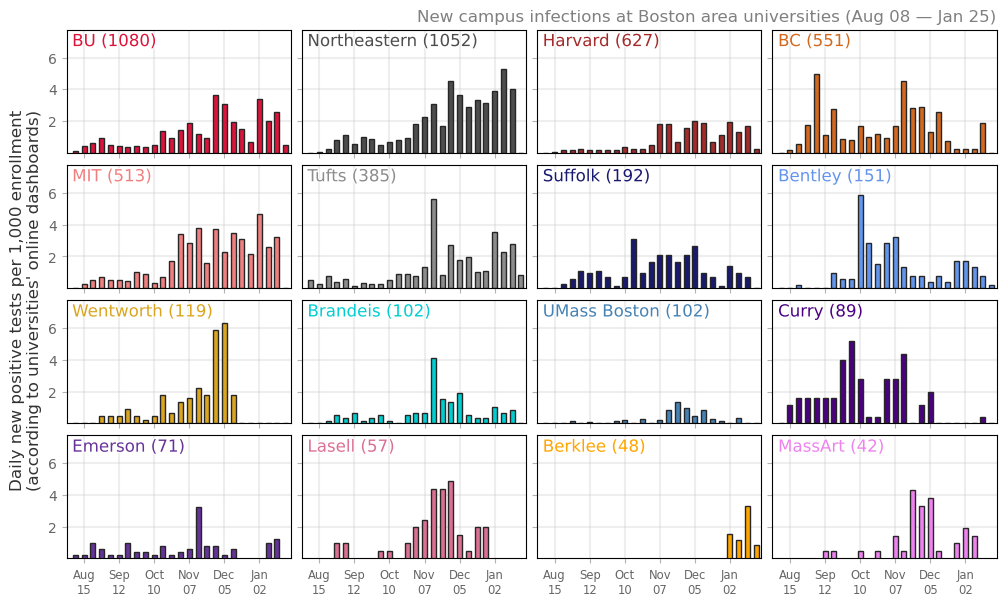

In [10]:
w = 3.0; h = 1.75
ncols = 4; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

for i, univ in enumerate(school_deets['name'].unique()[:16]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev_name'].values[0]

    data_u = boston_g.loc[(boston_g['university']==univ)&(boston_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = sum(data_u['positive_tests'].values)
    yvals_u = data_u['positive_tests'].values / data_u['enrollment'] * 1000
    
    ax[tups[i]].bar(xvals_u, yvals_u, fc=univ_col, ec='.15', lw=1, width=4)
    name = univ_abb + ' (%i)'%tot_cases
    text = ax[tups[i]].text(0.025, 0.965, name, transform=ax[tups[i]].transAxes,
                     color=univ_col, ha='left', va='top', fontsize='large')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

ax[(2,0)].set_ylabel("Daily new positive tests per 1,000 enrollment\n"+\
                     "(according to universities' online dashboards)",
                     color='.2',fontsize='large', y=1)
ax[(0,ncols-1)].set_title("New campus infections at Boston area universities (%s — %s)"%(
                          month_abbrev[data_u['date'].min()[5:7]]+" "+data_u['date'].min()[8:],
                          month_abbrev[today[5:7]]+" "+today[8:]),
                    x=1.0, ha='right', color='.5')

for a in fig.axes:
    datlabs = data_u['date'].unique()[1::4]
    a.set_ylim(0.025,7.75)
    a.set_xticks([date_dict[i] for i in datlabs])
    a.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in datlabs],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7')
    a.set_xlim(date_dict[start], date_dict[today]+2)


plt.savefig('../figs/pngs/university_boston_grid_per_1000.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_boston_grid_per_1000.pdf', bbox_inches='tight')

plt.show()

# Compare higher education cases with cases in the surrounding counties

In [11]:
data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
ll = pd.read_csv(data_url, delimiter=',', dtype={'fips':str, 'cases':float, 'deaths':float})

ll = ll.loc[(ll['fips'].isin(['25025','25021','25017']))&(ll['date']>start)].copy()
ll = ll.sort_values(['county','date'])

state_df = []
for st in ll.fips.unique():
    ll_st = ll.loc[ll['fips']==st].copy()

    ll_st['new_deaths'] = list(np.nan_to_num(ll_st['deaths'].diff().tolist()).astype(int))
    ll_st['new_cases'] = list(np.nan_to_num(ll_st['cases'].diff().tolist()).astype(int))

    ll_st.loc[ll_st['new_cases']<0,'new_cases'] = 0
    ll_st.loc[ll_st['new_deaths']<0,'new_deaths'] = 0
    state_df.append(ll_st)

ll = pd.concat(state_df).sort_values(['date','state']).reset_index().iloc[:,1:]
ll = ll.sort_values(['county','date'])
ll = ll.dropna().reset_index().iloc[:,1:]

In [12]:
boston_data = boston_data.loc[boston_data['university']!='University of Massachusetts-Amherst'].copy()

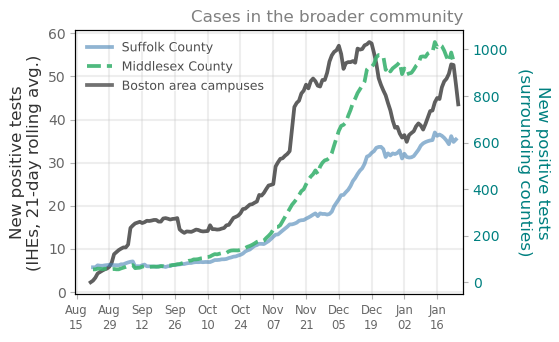

In [13]:
datlabs = data_u['date'].unique()[1::2]

wid = 21
fig, ax = plt.subplots(1,1,figsize=(5,3.5),dpi=100)

sch_df = boston_data.groupby('date').agg({'positive_tests':np.nansum}).reset_index()
allbost = sch_df['positive_tests'].rolling(window=wid).mean().values
bosdates = sch_df['date'].values

ax.plot([date_dict[i] for i in bosdates], allbost, label='Boston area campuses',
        color='.3', lw=lw*0.9, alpha=0.9,zorder=1)

ax.set_xticks([date_dict[i] for i in datlabs])
ax.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in datlabs],fontsize='small')
ax.set_xlim(date_dict['2020-08-15']-0.5, date_dict[today]+2)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')

ax.set_ylabel('New positive tests\n(IHEs, %i-day rolling avg.)'%wid,
                 color='.2',fontsize='large')

ax.set_title("Cases in the broader community", x=1.0, ha='right', color='.5')

ax2 = ax.twinx()

suffx = [date_dict[i] for i in ll.loc[ll['fips']=='25025']['date'].values]
suffy = ll.loc[ll['fips']=='25025']['new_cases'].rolling(window=wid).mean().values
ax2.plot(suffx, suffy, label='Suffolk County', color='steelblue', lw=lw*0.9, alpha=0.6)

middx = [date_dict[i] for i in ll.loc[ll['fips']=='25017']['date'].values]
middy = ll.loc[ll['fips']=='25017']['new_cases'].rolling(window=wid).mean().values
ax2.plot(middx, middy, label='Middlesex County', color='mediumseagreen', linestyle='--', lw=lw*0.9, alpha=0.9)
ax2.plot([0,0], [0,0], label='Boston area campuses', color='.3', lw=lw*0.9, alpha=0.8)

ax2.set_ylabel('New positive tests\n(surrounding counties)',
                 color='teal',fontsize='large',labelpad=30,rotation=270)
ax2.tick_params(axis='y', labelcolor='teal',color='.7')

l = ax2.legend(fontsize=9,framealpha=0.0,ncol=1,columnspacing=1.5,loc=2)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

plt.savefig('../figs/pngs/university_county_comparison_rawcases.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_county_comparison_rawcases.pdf', bbox_inches='tight')
plt.show()

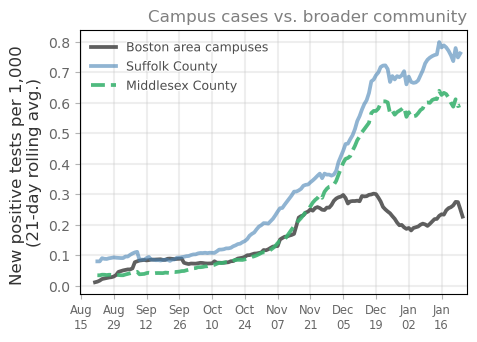

In [14]:
suffolk_population = 803907
middlesex_population = 1611699

datlabs = data_u['date'].unique()[1::2]

wid = 21
fig, ax = plt.subplots(1,1,figsize=(5,3.5),dpi=100)

sch_df = boston_data.groupby('date').agg({'positive_tests':np.nansum,
                                          'enrollment':np.nansum}).reset_index()
sch_df['positive_tests_per_1000'] = (sch_df['positive_tests'] / sch_df['enrollment']) * 1000
allbost = sch_df['positive_tests_per_1000'].rolling(window=wid).mean().values
bosdates = sch_df['date'].values

ax.plot([date_dict[i] for i in bosdates], allbost, label='Boston area campuses',
        color='.3', lw=lw*0.9, alpha=0.9,zorder=1)

ax.set_xticks([date_dict[i] for i in datlabs])
ax.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in datlabs],fontsize='small')
ax.set_xlim(date_dict['2020-08-15']-0.5, date_dict[today]+2)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')

ax.set_ylabel('New positive tests per 1,000 \n(%i-day rolling avg.)'%wid,
                 color='.2',fontsize='large')

ax.set_title("Campus cases vs. broader community", x=1.0, ha='right', color='.5')

suffx = [date_dict[i] for i in ll.loc[ll['fips']=='25025']['date'].values]
suffy = (ll.loc[ll['fips']=='25025']['new_cases'].rolling(window=wid).mean().values / suffolk_population) * 1000
ax.plot(suffx, suffy, label='Suffolk County', color='steelblue', lw=lw*0.9, alpha=0.6)

middx = [date_dict[i] for i in ll.loc[ll['fips']=='25017']['date'].values]
middy = (ll.loc[ll['fips']=='25017']['new_cases'].rolling(window=wid).mean().values / middlesex_population) * 1000
ax.plot(middx, middy, label='Middlesex County', color='mediumseagreen', linestyle='--', lw=lw*0.9, alpha=0.9)

l = ax.legend(fontsize=9,framealpha=0.0,ncol=1,columnspacing=1.5,loc=2)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

plt.savefig('../figs/pngs/university_county_comparison_cases_per_1000.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_county_comparison_cases_per_1000.pdf', bbox_inches='tight')
plt.show()

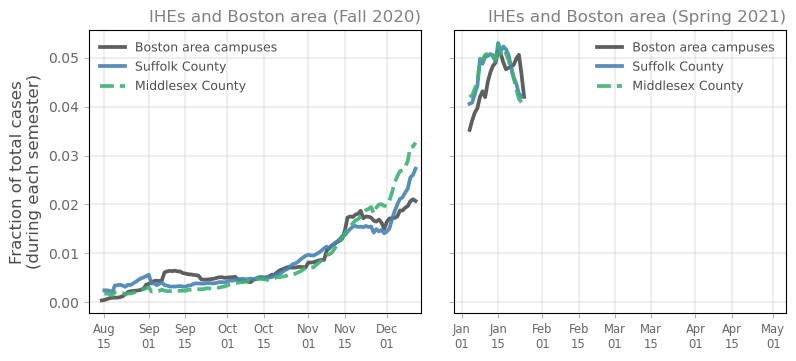

In [15]:
dat_labs1 = ['2020-08-15','2020-09-01','2020-09-15','2020-10-01','2020-10-15',
             '2020-11-01','2020-11-15','2020-12-01','2020-12-15']
dat_labs2 = ['2021-01-01','2021-01-15','2021-02-01','2021-02-15',
             '2021-03-01','2021-03-15','2021-04-01','2021-04-15','2021-05-01']

wid = 14
fig, ax = plt.subplots(1,2,figsize=(9,3.75),dpi=100,sharey=True)
plt.subplots_adjust(wspace=0.1)
fal_date = '2020-12-13'
sch_df = boston_data.loc[boston_data['date']<fal_date].groupby('date').agg(
                            {'positive_tests':np.nansum}).reset_index()
allbost = sch_df['positive_tests'].rolling(window=wid).mean().values
bosdates = sch_df['date'].values

suffx = [date_dict[i] for i in ll.loc[(ll['fips']=='25025')&(ll['date']<fal_date)]['date'].values]
suffy = ll.loc[(ll['fips']=='25025')&(ll['date']<fal_date)]['new_cases'].rolling(window=wid).mean().values
middx = [date_dict[i] for i in ll.loc[(ll['fips']=='25017')&(ll['date']<fal_date)]['date'].values]
middy = ll.loc[(ll['fips']=='25017')&(ll['date']<fal_date)]['new_cases'].rolling(window=wid).mean().values

ax[0].plot([date_dict[i] for i in bosdates], allbost/np.nansum(allbost), label='Boston area campuses',
        color='.3', lw=lw*0.9, alpha=0.9,zorder=1)
ax[0].plot(suffx, suffy/np.nansum(suffy), label='Suffolk County',
        color='steelblue', lw=lw*0.9, alpha=0.9,zorder=1)
ax[0].plot(middx, middy/np.nansum(middy), label='Middlesex County',
        color='mediumseagreen', lw=lw*0.9, alpha=0.9,zorder=1,linestyle='--')
ax[0].set_xticks([date_dict[i] for i in dat_labs1])
ax[0].set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in dat_labs1],fontsize='small')
ax[0].set_xlim(date_dict['2020-08-10']-1, date_dict[fal_date]+1)
ax[0].grid(linewidth=1.5,color='.75',alpha=0.25)
ax[0].tick_params(labelcolor='.4',color='.7')
ax[0].set_ylabel('Fraction of total cases\n(during each semester)',
                 color='.3',fontsize='large')
ax[0].set_title("IHEs and Boston area (Fall 2020)", x=1.0, ha='right', color='.5')
l = ax[0].legend(fontsize=9,framealpha=0.0,ncol=1,columnspacing=1.5,loc=2)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

spr_date = '2020-12-21'
sum_date = '2021-05-05'
sch_df = boston_data.loc[boston_data['date']>spr_date].groupby('date').agg(
                            {'positive_tests':np.nansum}).reset_index()
allbost = sch_df['positive_tests'].rolling(window=wid).mean().values
bosdates = sch_df['date'].values
suffx = [date_dict[i] for i in ll.loc[(ll['fips']=='25025')&(ll['date']>spr_date)]['date'].values]
suffy = ll.loc[(ll['fips']=='25025')&(ll['date']>spr_date)]['new_cases'].rolling(window=wid).mean().values
middx = [date_dict[i] for i in ll.loc[(ll['fips']=='25017')&(ll['date']>spr_date)]['date'].values]
middy = ll.loc[(ll['fips']=='25017')&(ll['date']>spr_date)]['new_cases'].rolling(window=wid).mean().values

ax[1].plot([date_dict[i] for i in bosdates], allbost/np.nansum(allbost), label='Boston area campuses',
        color='.3', lw=lw*0.9, alpha=0.9,zorder=1)
ax[1].plot(suffx, suffy/np.nansum(suffy), label='Suffolk County',
        color='steelblue', lw=lw*0.9, alpha=0.9,zorder=1)
ax[1].plot(middx, middy/np.nansum(middy), label='Middlesex County',
        color='mediumseagreen', lw=lw*0.9, alpha=0.9,zorder=1,linestyle='--')
ax[1].set_xticks([date_dict[i] for i in dat_labs2])
ax[1].set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in dat_labs2],fontsize='small')
ax[1].set_xlim(date_dict['2021-01-01']-3, date_dict[sum_date]+1)
ax[1].grid(linewidth=1.5,color='.75',alpha=0.25)
ax[1].tick_params(labelcolor='.4',color='.7')
ax[1].set_title("IHEs and Boston area (Spring 2021)", x=1.0, ha='right', color='.5')
l = ax[1].legend(fontsize=9,framealpha=0.0,ncol=1,columnspacing=1.5)#,loc=2)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

plt.savefig('../figs/pngs/university_county_comparison_spr_fall.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_county_comparison_spr_fall.pdf', bbox_inches='tight')

plt.show()